# Calibrated Explanations for Binary Classification
## Demonstrated on the diabetes data set

Author: Tuwe Löfström (tuwe.lofstrom@ju.se)  
Copyright 2023 Tuwe Löfström  
License: BSD 3 clause
Sources:
1. ["Calibrated Explanations: with Uncertainty Information and Counterfactuals"](https://arxiv.org/abs/2305.02305) by [Helena Löfström](https://github.com/Moffran), [Tuwe Löfström](https://github.com/tuvelofstrom), Ulf Johansson, and Cecilia Sönströd.

### 1. Import packages, data and train an underlying model
#### 1.1 Import packages

In the examples below, we will be using `NumPy`, `pandas`, and `sklearn`.  `CalibratedExplainer` and `VennAbers` are imported from `calibrated_explanations`. `VennAbers` is used to demonstrate how it can be used to calibrate an underlying model. 

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from lime.lime_tabular import LimeTabularExplainer

from calibrated_explanations import CalibratedExplainer, VennAbers, __version__

print(f"calibrated_explanations {__version__}")


calibrated_explanations v0.3.0


#### 1.2 Import data and train a model
Let us import the Califronia Housing data set (see sources at the top).

# Diabetes

In [7]:
num_to_test = 6 # number of instances to test, 3 from each class
dataSet = 'diabetes_full'
delimiter = ','
model = 'RF'
# print(dataSet)

fileName = '../data/' + dataSet + ".csv"
df = pd.read_csv(fileName, delimiter=delimiter)
target = 'Y'
X, y = df.drop(target,axis=1), df[target] 
# df.head()

Let us split the data set into a training and a test set, and further split the training set into a proper training set and a calibration set. 

In [8]:
no_of_classes = len(np.unique(y))
no_of_features = X.shape[1]
no_of_instances = X.shape[0]

# find categorical features
categorical_features = [i for i in range(no_of_features) if len(np.unique(X.iloc[:,i])) < 10]

# select test instances from each class and split into train, cal and test
idx = np.argsort(y.values).astype(int)
X, y = X.values[idx,:], y.values[idx]
test_index = np.array([*range(int(num_to_test/2)), *range(no_of_instances-1, no_of_instances-int(num_to_test/2)-1,-1)])
train_index = np.setdiff1d(np.array(range(no_of_instances)), test_index)   
X_train, X_test = X[train_index,:], X[test_index,:]
y_train, y_test = y[train_index], y[test_index]
X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train, test_size=0.33,random_state=42, stratify=y_train)

print(y_test)
print(categorical_features)

[0 0 0 1 1 1]
[]


Let us fit a random forest to the proper training set. We also set a random seed to be able to rerun the notebook and get the same results.

In [9]:
model = RandomForestClassifier()

model.fit(X_prop_train,y_prop_train)  

RandomForestClassifier()

Create the `CalibratedExplainer` by feeding the model and the calibration set as a minimum (mode is 'classification' by default). 

In [10]:
ce = CalibratedExplainer(model, 
                        X_cal, 
                        y_cal,
                        feature_names=df.columns,                    
                        categorical_features=categorical_features, 
                        class_labels={0:'Non-diabetic',1:'Diabetic'})
display(ce)

C:\Users\loftuw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\venn_abers\venn_abers.py:102: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


CalibratedExplainer:
	                mode=classification
	                discretizer=<class 'NoneType'>
	                model=RandomForestClassifier()
	                

#### Regular and uncertainty explanations
When using regular or uncertainty plots, the recommended (and for classification default) `Discretizer` is the `BinaryEntropyDiscretizer`. As no discretizer was assigned at initialization, it is already assigned `BinaryEntropyDiscretizer`. 

Once the explanations are extracted, we can visualize them using regular or uncertainty plots. The regular plot include an uncertainty interval for each class and the weights of the most influential features. The weights (positive or negative) always indicate the impact on the blue class. However, the colors are used to indicate which class is positively affected. Negative (red) weights are reducing the probability of the blue class and increasing the probability of the red class. 

Regular plots are shown by calling the function `plot`, with `n_features_to_show` indicating the number of features to include, in order of importance. To save the plots to disk, `save_ext` can take one or several of the following extensions `['pdf','svg','png']` creating a plot for each instance and file format. 

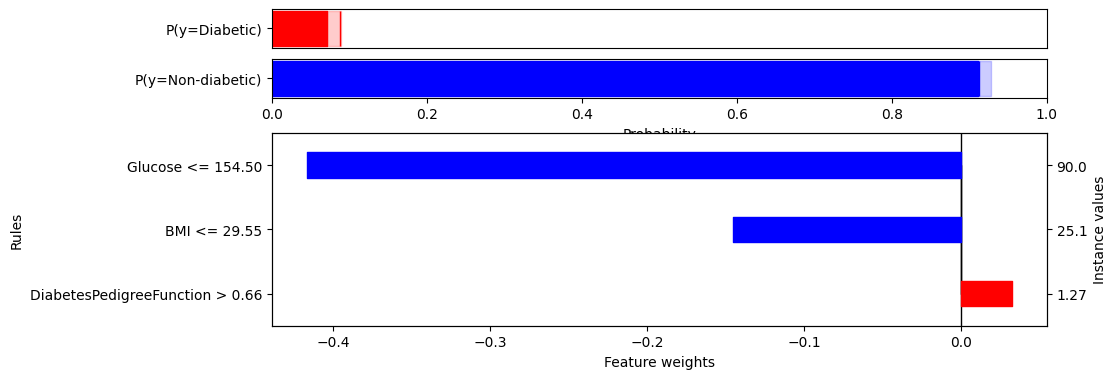

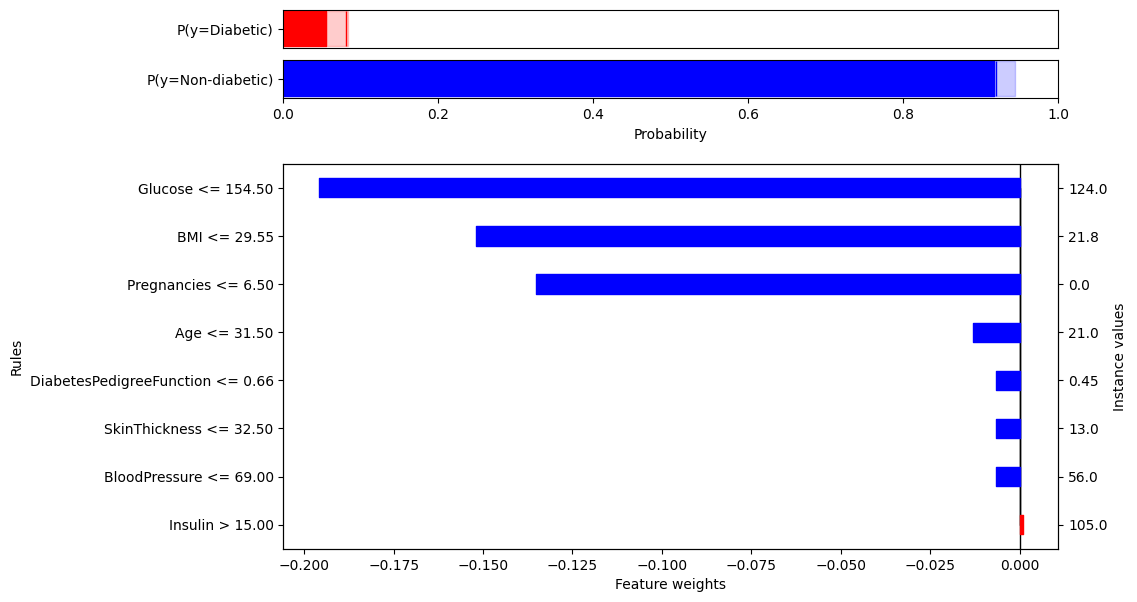

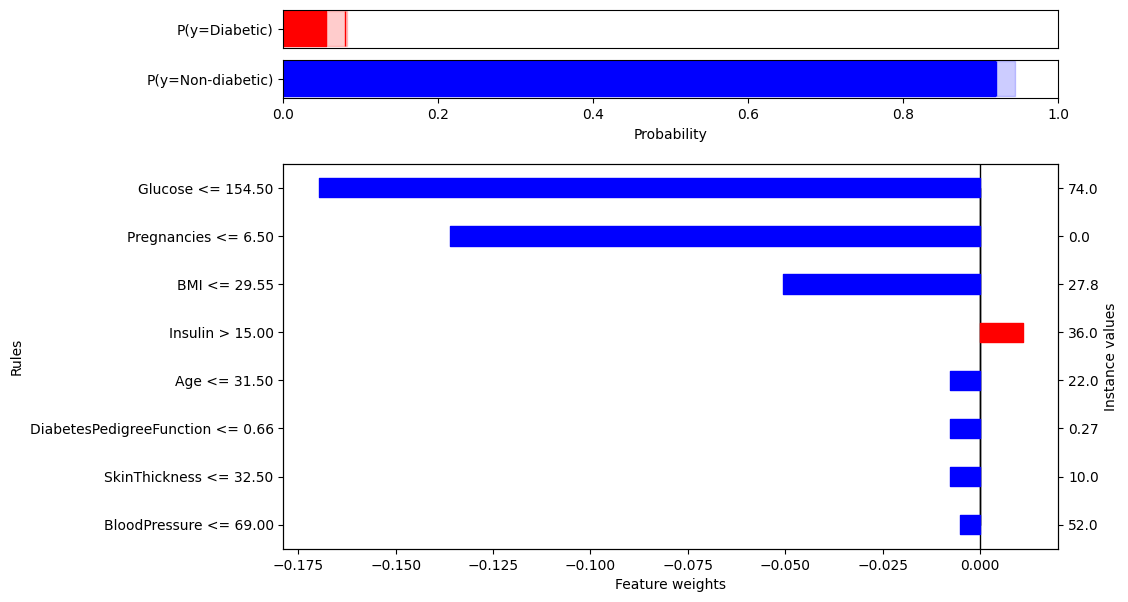

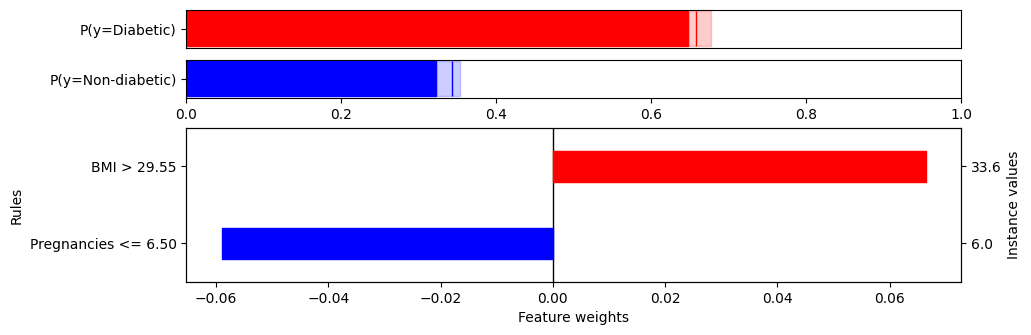

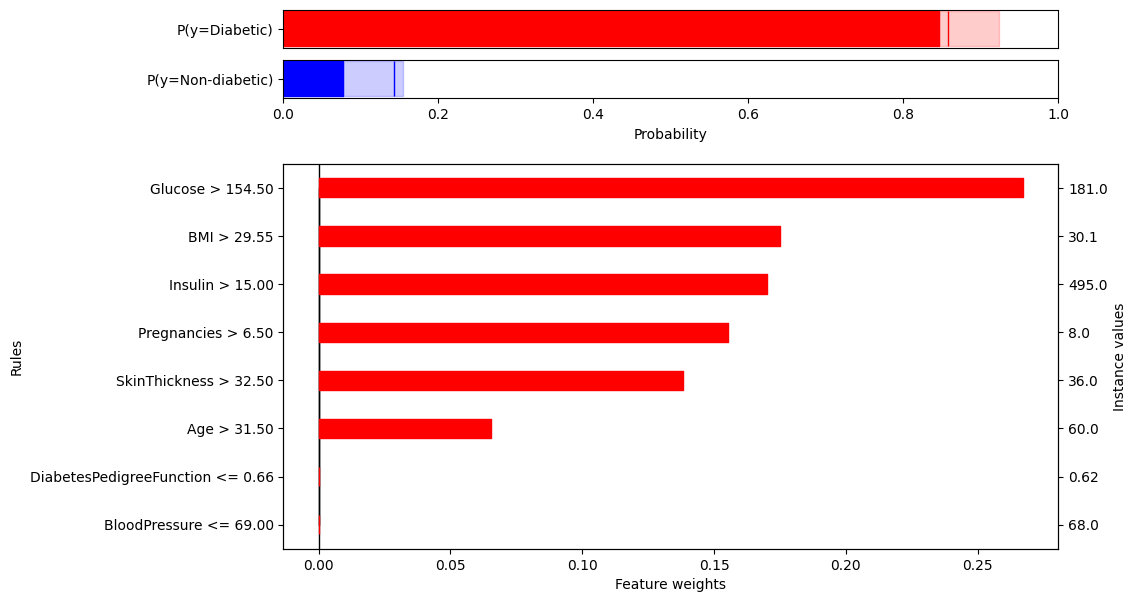

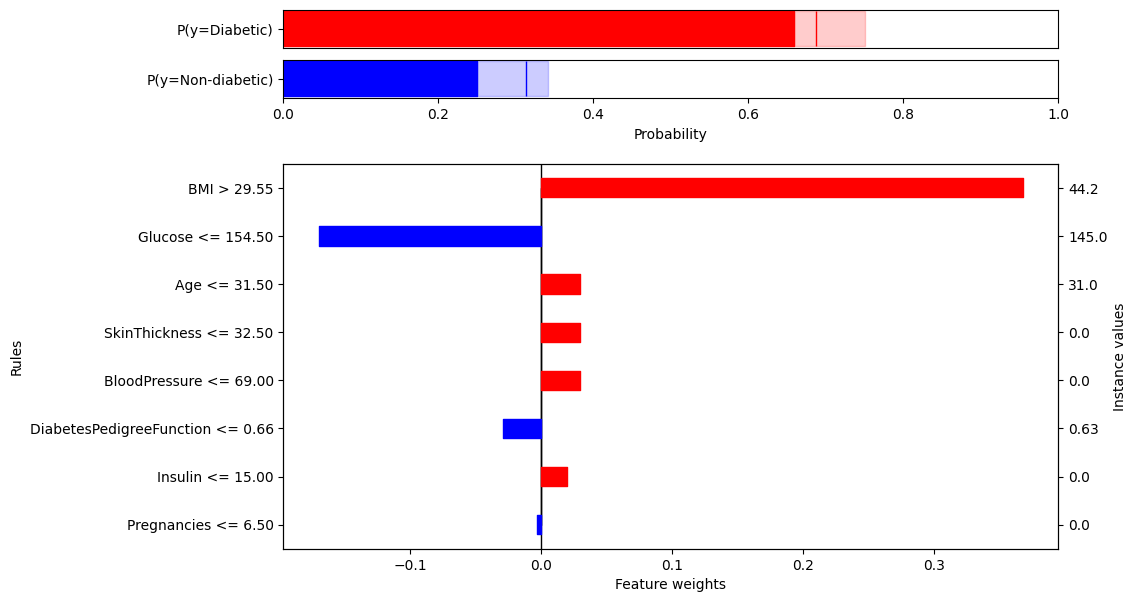

In [11]:
factual_explanation = ce.explain_factual(X_test)
factual_explanation.plot(filename='../results/diabetes.pdf')

Uncertainty plots are similar to regular plots but also provide an uncertainty estimate for the impact of each feature. Here, the shaded area is the range of possible changes that each feature can result in.

To get uncertainty plots, simply call `plot` with the parameter `uncertainty=True`.

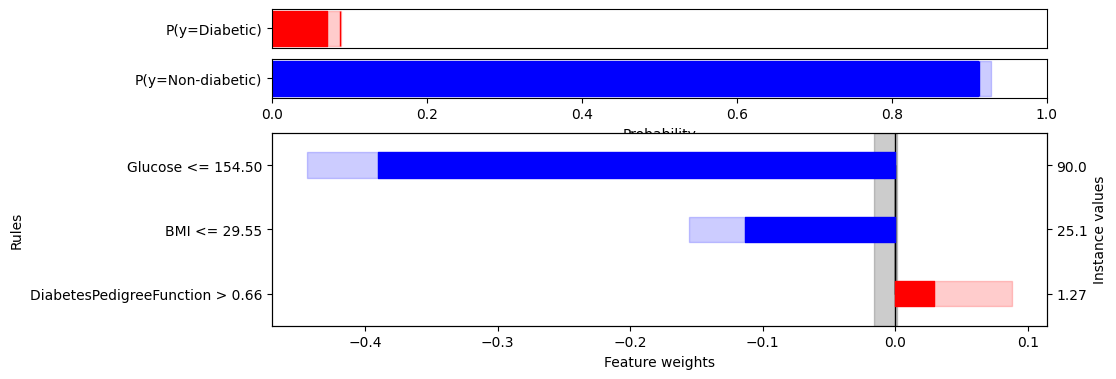

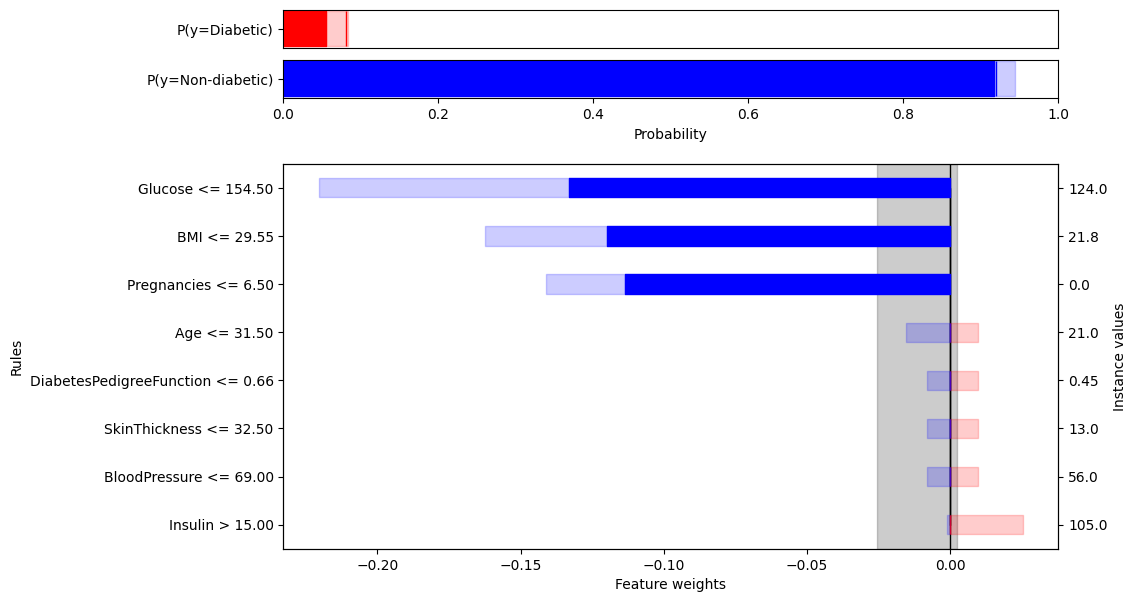

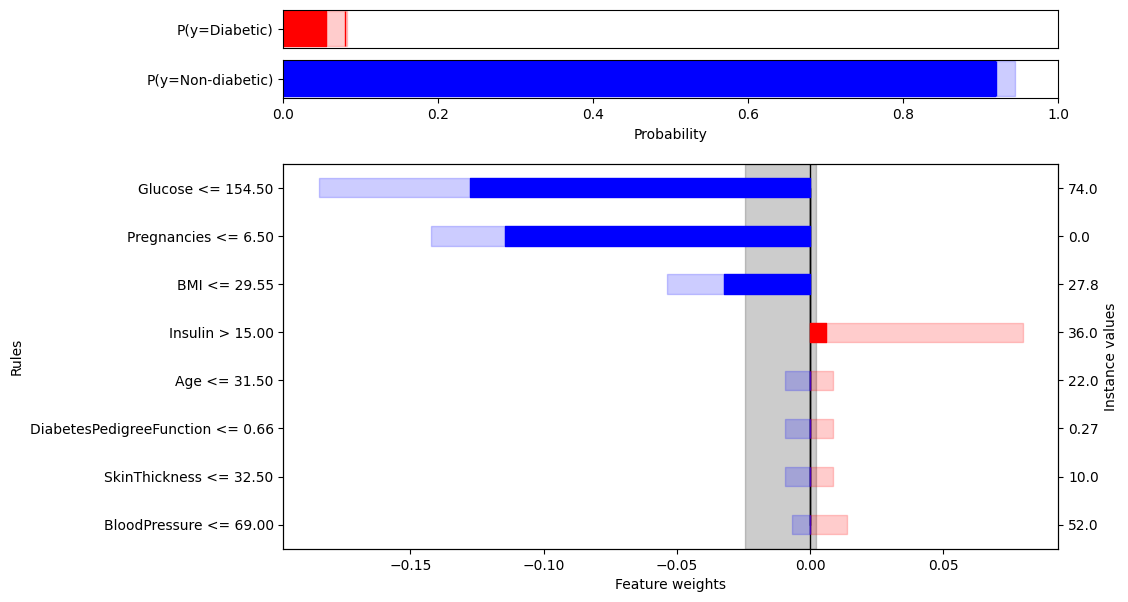

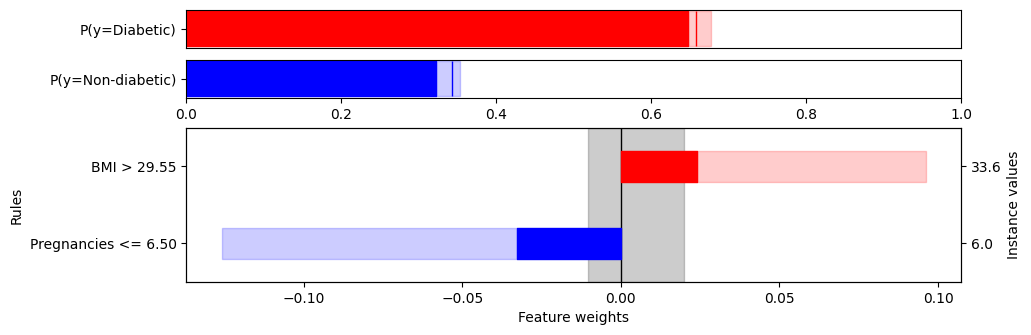

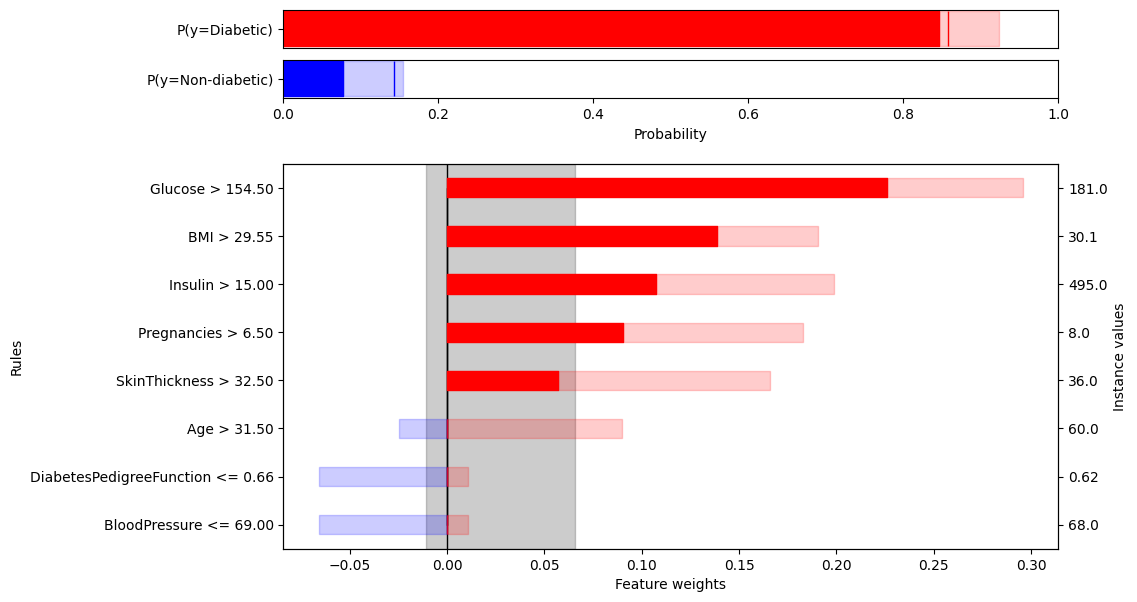

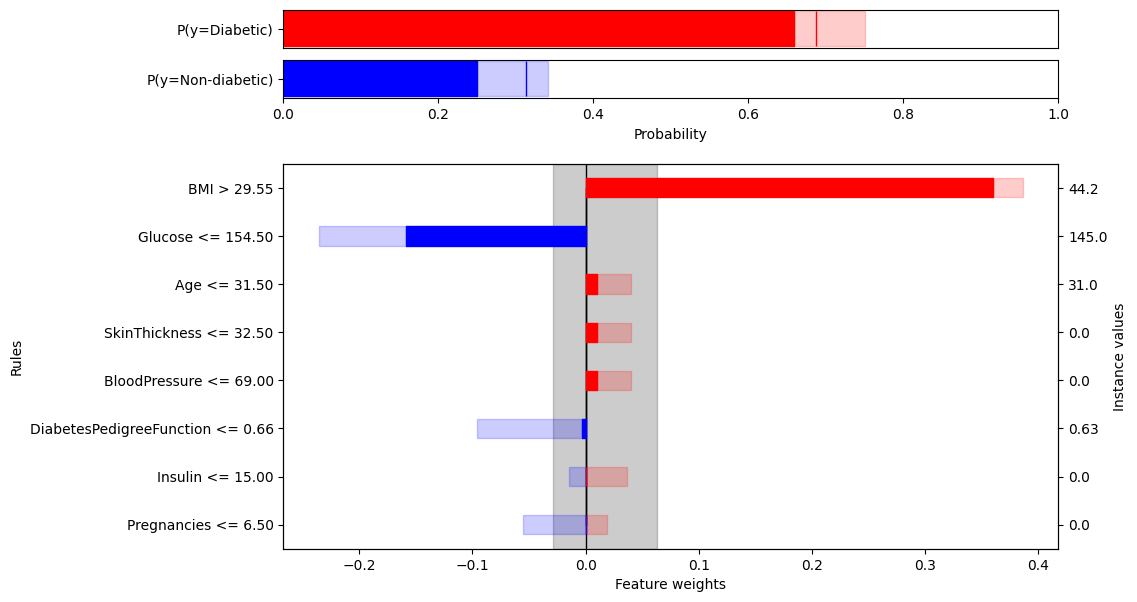

In [12]:
factual_explanation.plot(filename='../results/diabetes_uncertainty.pdf', uncertainty=True)

#### Conjunctive rules
In the examples above, each explanation only contained atomic rules, including a single feature. It is also possible to combine rules and see the combined impact of more than one feature.

In [13]:
# Not used in paper
# factual_explanation.add_conjunctions()
# factual_explanation.plot(filename='../results/diabetes_conjunctive.pdf', n_features_to_show=15)
# factual_explanation.plot(filename='../results/diabetes_uncertainty_conjunctive.pdf', uncertainty=True, n_features_to_show=15)

#### Counterfactual explanations
When using counterfactual explanations, the recommended `Discretizer` is the `EntropyDiscretizer`. The discretizer can be changed into `EntropyDiscretizer` by invoking `set_discretizer('entropy')`. Counterfactual explanations are extracted in the same way as regular and uncertainty explanations. The `EntropyDiscretizer` allows for more varied and precise counterfactual rules. The function `explore_alternatives` will automatically assign recommended discretizer.

Once the explanations are extracted, we can visualize them using `plot` function. The counterfactual plot visualize the probability interval for the positive class (`Diabetic` in this example). The counterfactual rules indicate what the interval would have changed into had the feature values changed according to the rule condition.

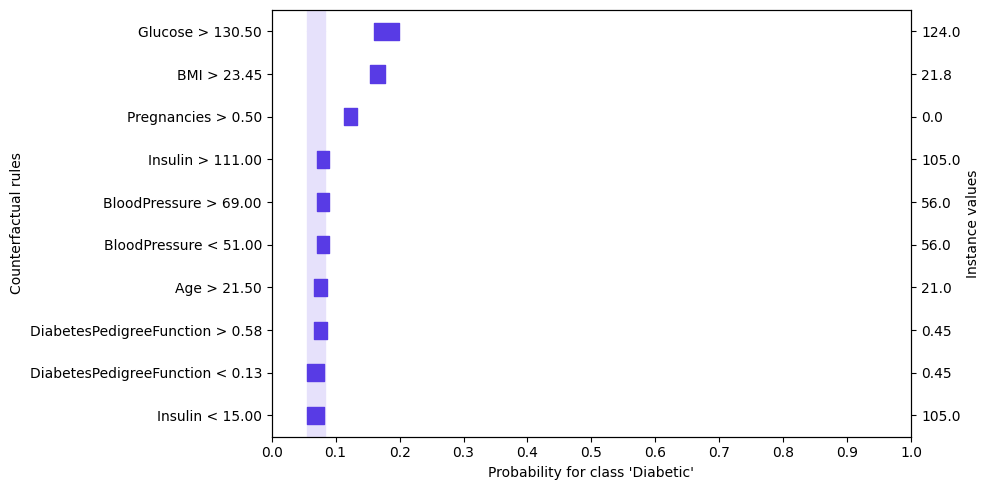

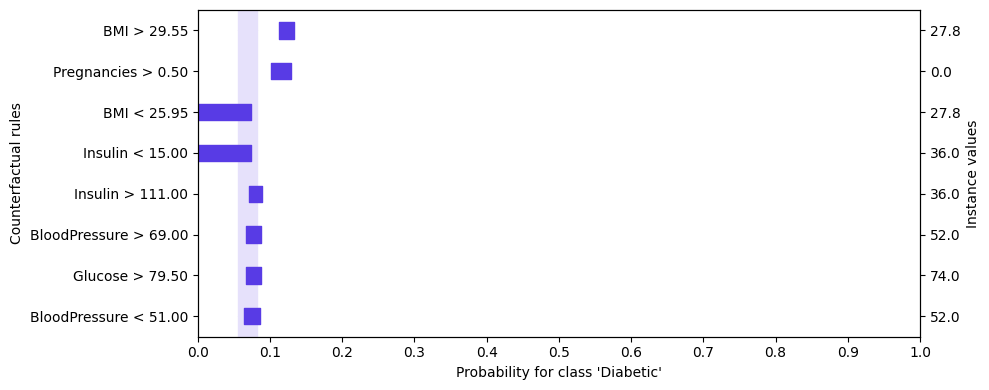

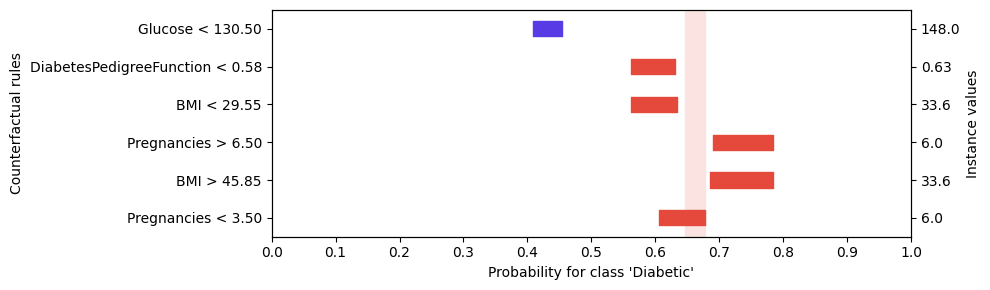

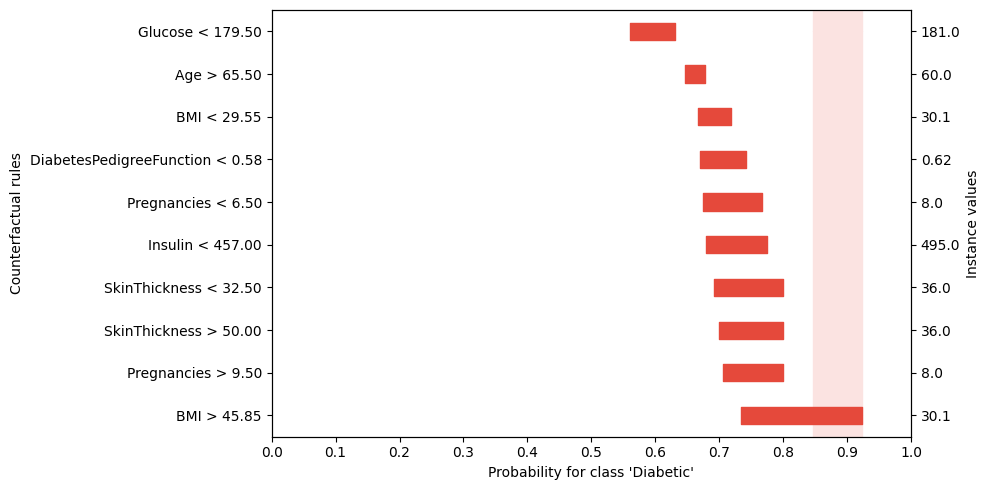

In [14]:
alternative_explanation = ce.explore_alternatives(X_test)
alternative_explanation.plot(filename='../results/diabetes_alternative.pdf')

#### Conjunctional counterfactual explanations
As with regular and uncertainty explanations, conjunctions can also be used for counterfactual explanations.

As the `add_conjunctions` functions return the explanation object, they can be stacked.

In [15]:
# Not used in paper
# alternative_explanation.add_conjunctions().plot(filename='../results/diabetes_alternative_conjunctive.pdf', n_features_to_show=15)

# Liver

In [16]:
num_to_test = 6 # number of instances to test, 3 from each class
dataSet = 'liver_full'
delimiter = ';'
model = 'RF'
# print(dataSet)

fileName = '../data/' + dataSet + ".csv"
df = pd.read_csv(fileName, delimiter=delimiter)
target = 'Y'
X, y = df.drop(target,axis=1), df[target] 
# df.head()

In [17]:
no_of_classes = len(np.unique(y))
no_of_features = X.shape[1]
no_of_instances = X.shape[0]

# find categorical features
categorical_features = [i for i in range(no_of_features) if len(np.unique(X.iloc[:,i])) < 10]

# select test instances from each class and split into train, cal and test
idx = np.argsort(y.values).astype(int)
X, y = X.values[idx,:], y.values[idx]
test_index = np.array([*range(int(num_to_test/2)), *range(no_of_instances-1, no_of_instances-int(num_to_test/2)-1,-1)])
train_index = np.setdiff1d(np.array(range(no_of_instances)), test_index)   
X_train, X_test = X[train_index,:], X[test_index,:]
y_train, y_test = y[train_index], y[test_index]
X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train, test_size=0.33,random_state=42, stratify=y_train)

print(y_test)
print(categorical_features)

[0 0 0 1 1 1]
[]


In [18]:
model = RandomForestClassifier()

model.fit(X_prop_train,y_prop_train)  

RandomForestClassifier()

In [19]:
ce = CalibratedExplainer(model, 
                        X_cal, 
                        y_cal,
                        feature_names=df.columns,                    
                        categorical_features=categorical_features, 
                        class_labels={0:'Healthy',1:'Sick'})
display(ce)

CalibratedExplainer:
	                mode=classification
	                discretizer=<class 'NoneType'>
	                model=RandomForestClassifier()
	                

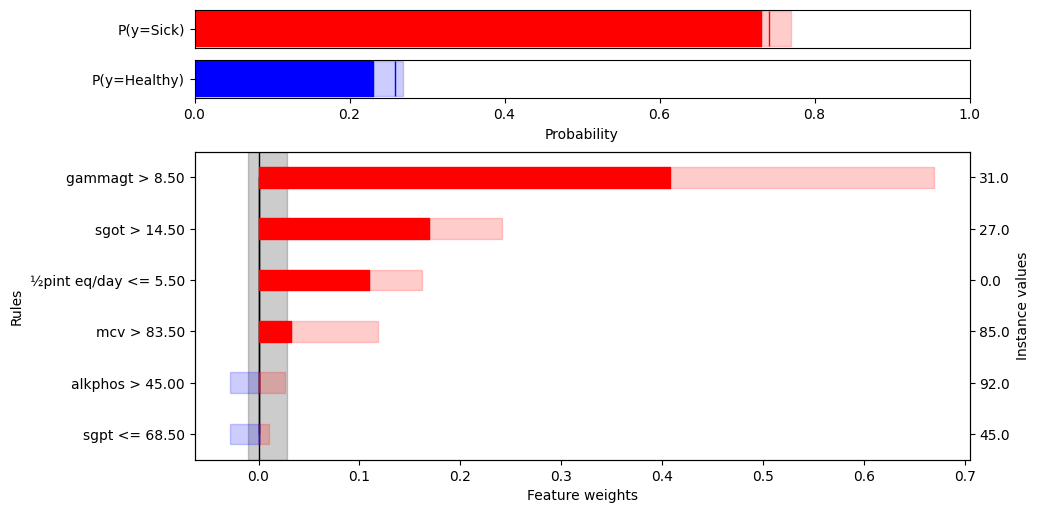

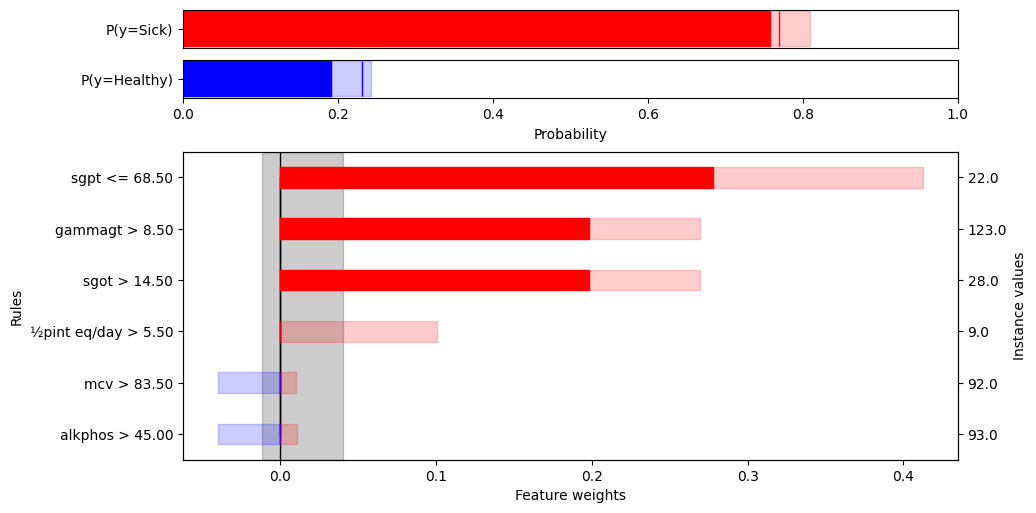

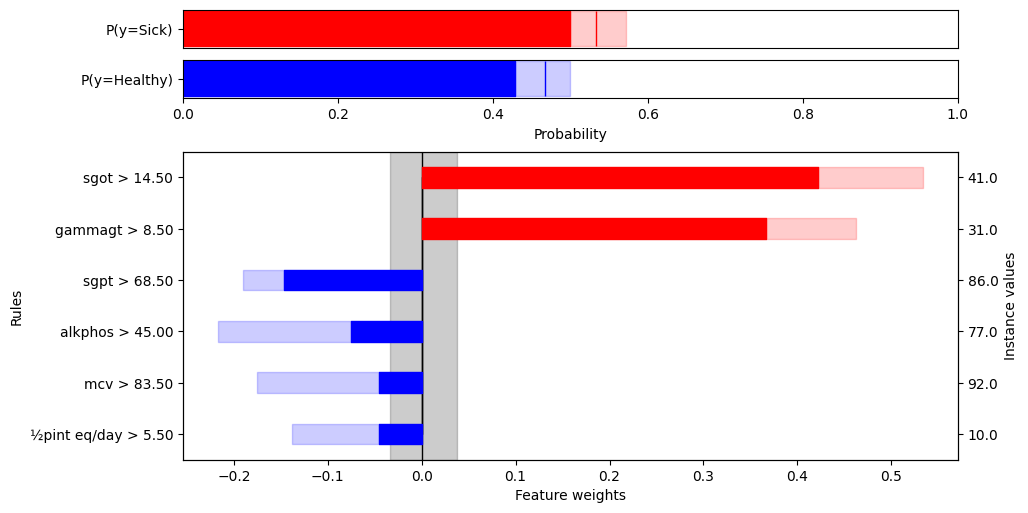

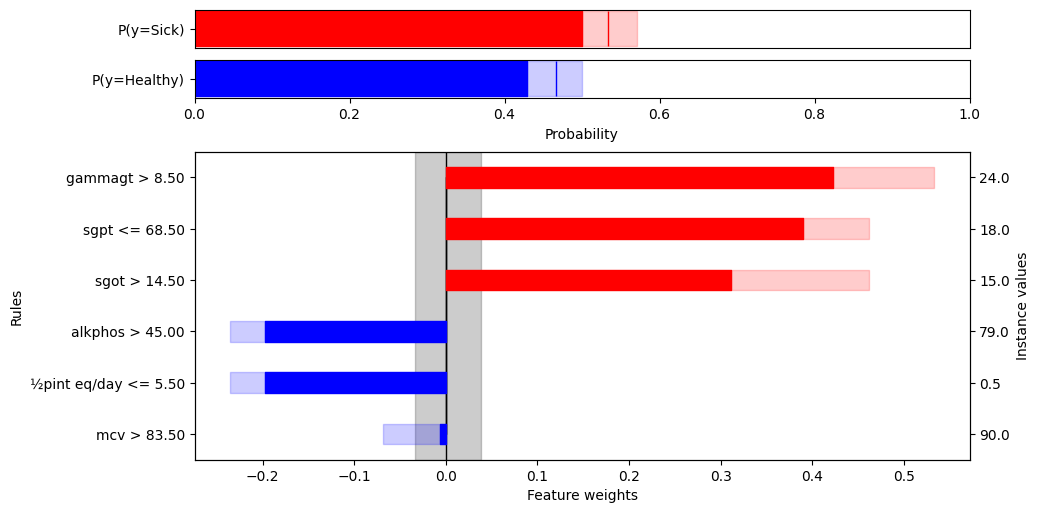

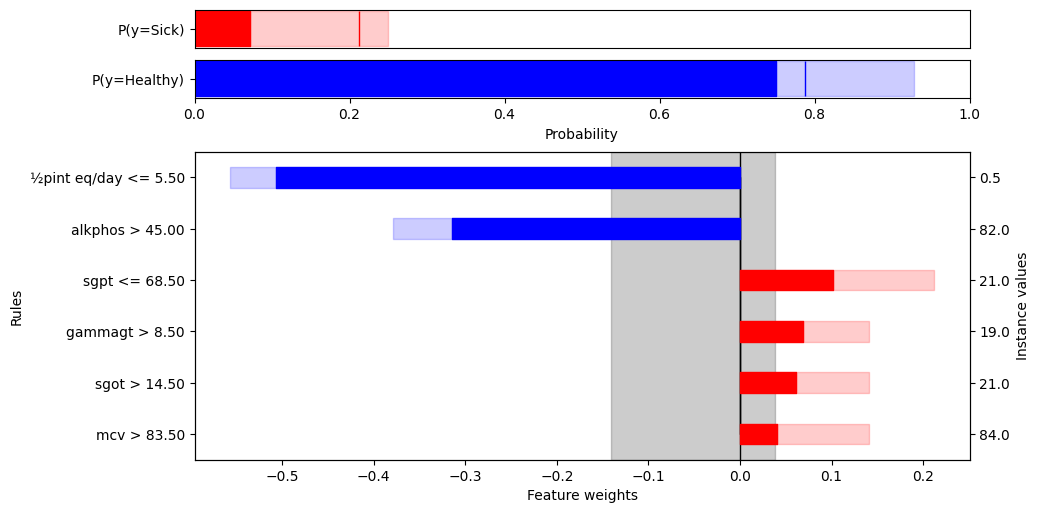

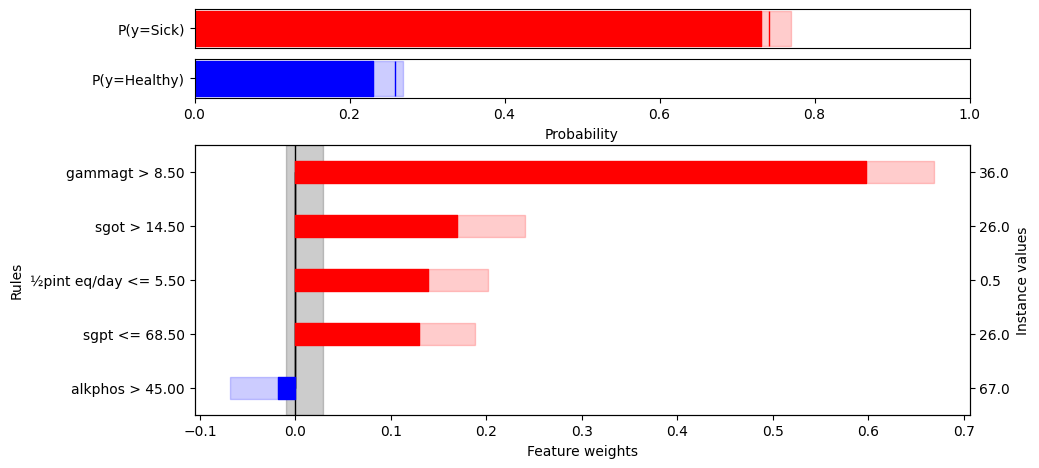

In [20]:
factual_explanation = ce.explain_factual(X_test)
# Not used in paper
# factual_explanation.plot(filename='../results/liver.pdf')
factual_explanation.plot(filename='../results/liver_uncertainty.pdf', uncertainty=True)
# Not used in paper
# factual_explanation.add_conjunctions()
# factual_explanation.plot(filename='../results/liver_conjunctive.pdf', n_features_to_show=15)
# factual_explanation.plot(filename='../results/liver_uncertainty_conjunctive.pdf', uncertainty=True, n_features_to_show=15)

In [21]:
# Not used in paper
# alternative_explanation = ce.explore_alternatives(X_test)
# alternative_explanation.plot(filename='../results/liver_alternative.pdf')

In [22]:
# Not used in paper
# alternative_explanation.add_conjunctions()
# alternative_explanation.plot(filename='../results/liver_alternative_conjunctive.pdf', n_features_to_show=15)

# Vote

In [23]:
num_to_test = 6 # number of instances to test, 3 from each class
dataSet = 'vote_full'
delimiter = ';'
model = 'RF'
# print(dataSet)

fileName = '../data/' + dataSet + ".csv"
df = pd.read_csv(fileName, delimiter=delimiter)
target = 'Y'
X, y = df.drop(target,axis=1), df[target] 
# df.head()

In [24]:
no_of_classes = len(np.unique(y))
no_of_features = X.shape[1]
no_of_instances = X.shape[0]

# find categorical features
categorical_features = [i for i in range(no_of_features) if len(np.unique(X.iloc[:,i])) < 10]

# select test instances from each class and split into train, cal and test
idx = np.argsort(y.values).astype(int)
X, y = X.values[idx,:], y.values[idx]
test_index = np.array([*range(int(num_to_test/2)), *range(no_of_instances-1, no_of_instances-int(num_to_test/2)-1,-1)])
train_index = np.setdiff1d(np.array(range(no_of_instances)), test_index)   
X_train, X_test = X[train_index,:], X[test_index,:]
y_train, y_test = y[train_index], y[test_index]
X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train, test_size=0.33,random_state=42, stratify=y_train)

print(y_test)
print(categorical_features)

[0 0 0 1 1 1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [25]:
model = RandomForestClassifier()

model.fit(X_prop_train,y_prop_train)  

RandomForestClassifier()

In [26]:
ce = CalibratedExplainer(model, 
                        X_cal, 
                        y_cal,
                        feature_names=df.columns,                    
                        categorical_features=categorical_features, 
                        class_labels={0:'Republican',1:'Democrat'})
display(ce)

CalibratedExplainer:
	                mode=classification
	                discretizer=<class 'NoneType'>
	                model=RandomForestClassifier()
	                

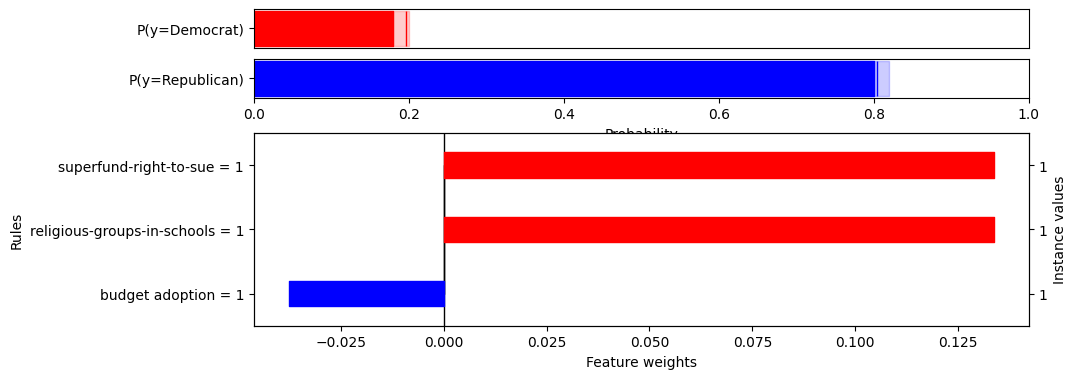

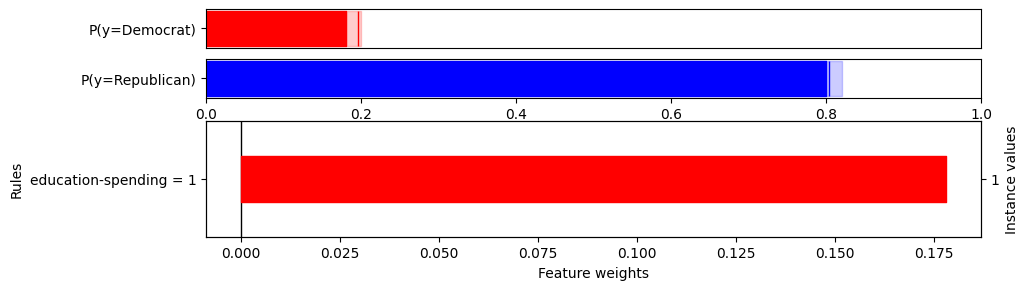

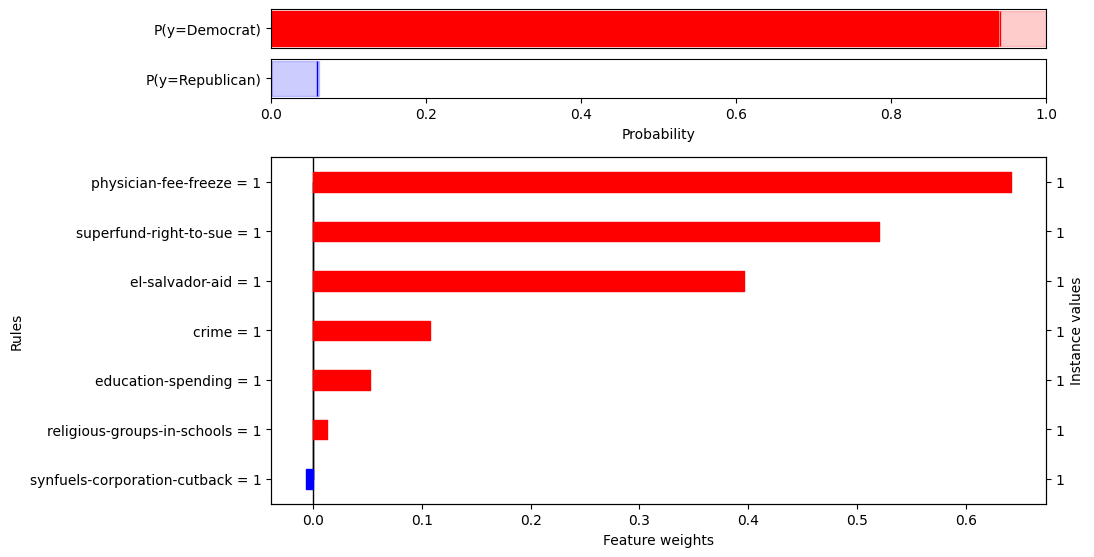

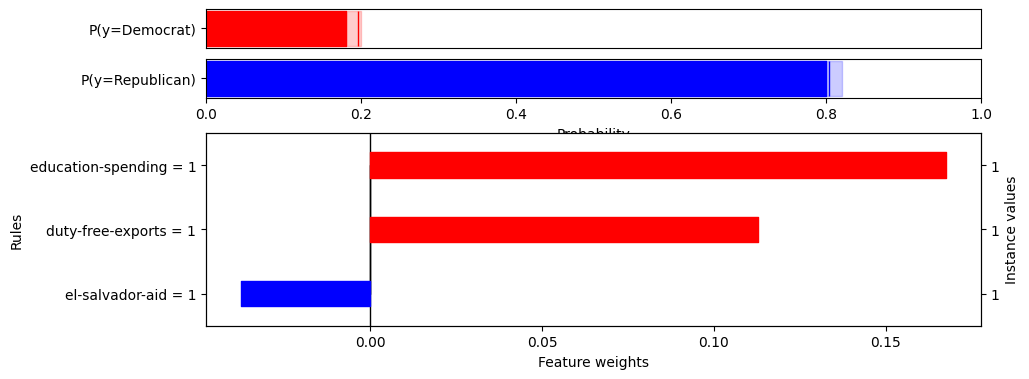

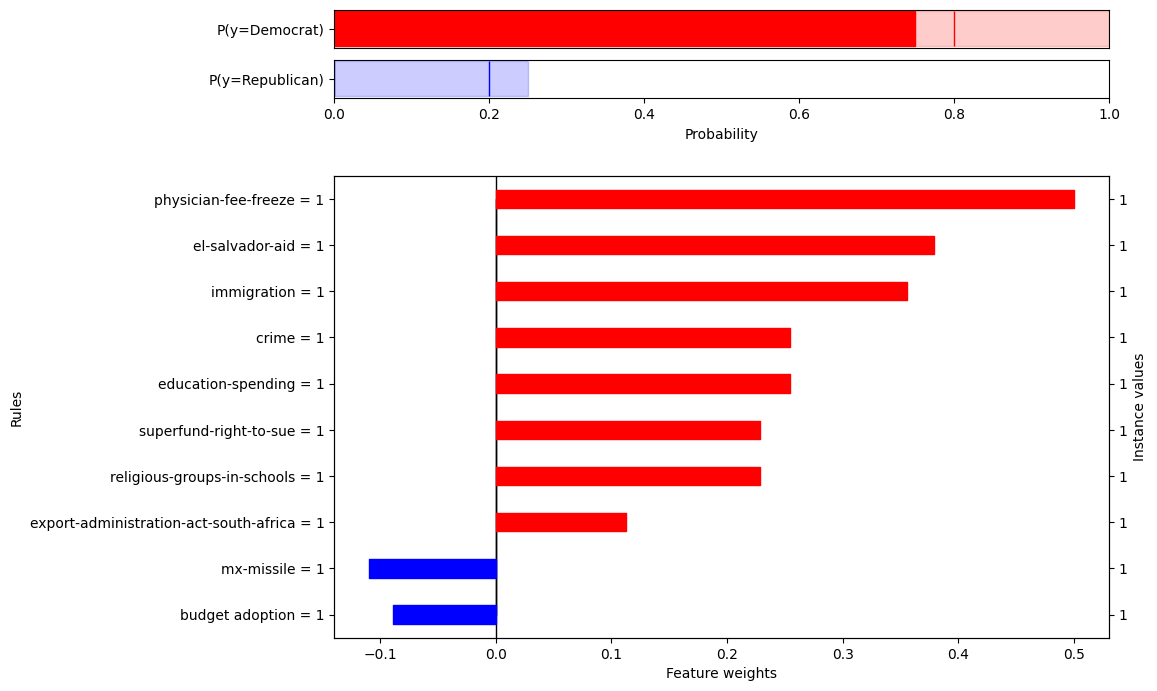

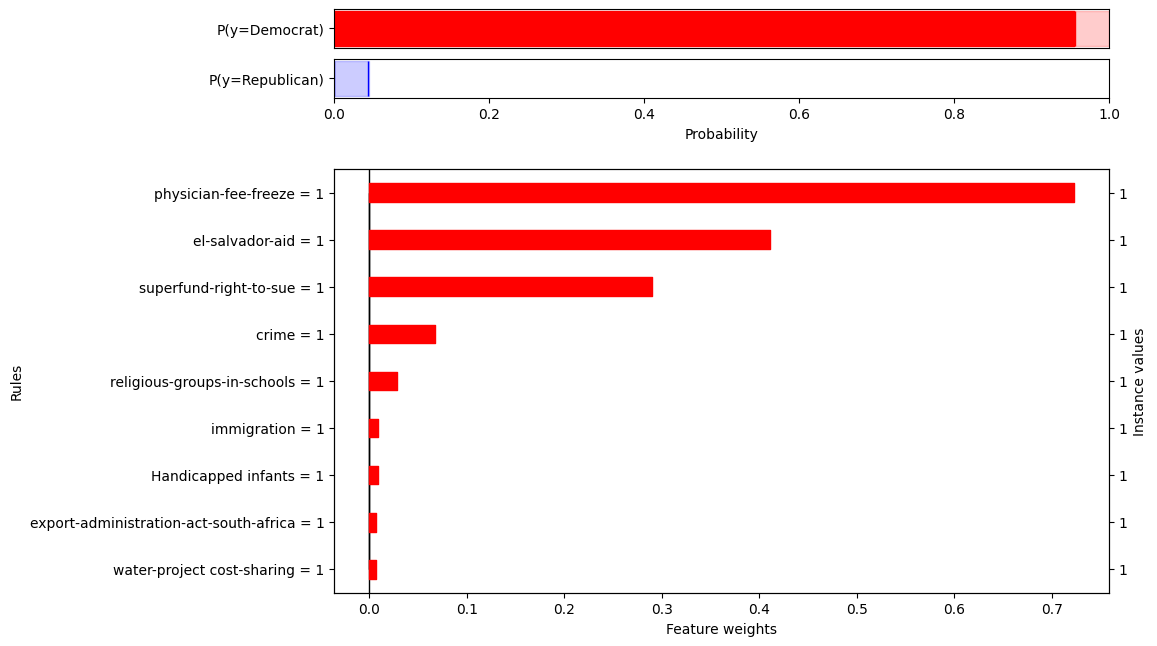

In [27]:
factual_explanation = ce.explain_factual(X_test)
factual_explanation.plot(filename='../results/vote.pdf')
# Not used in paper
# factual_explanation.plot(filename='../results/vote_uncertainty.pdf', uncertainty=True)
# factual_explanation.add_conjunctions()
# factual_explanation.plot(filename='../results/vote_conjunctive.pdf', n_features_to_show=15)
# factual_explanation.plot(filename='../results/vote_uncertainty_conjunctive.pdf', uncertainty=True, n_features_to_show=15)

C:\Users\loftuw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\calibrated_explanations\_explanations.py:1445: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


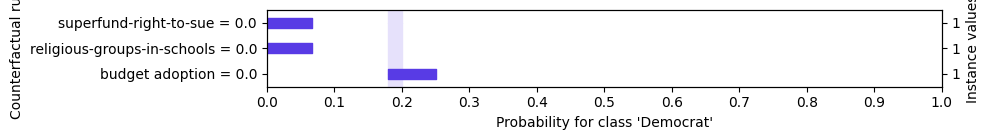

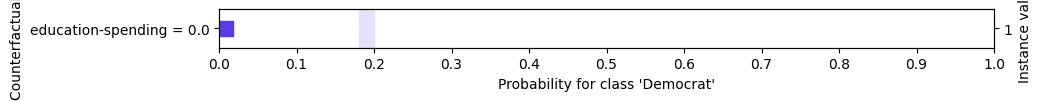

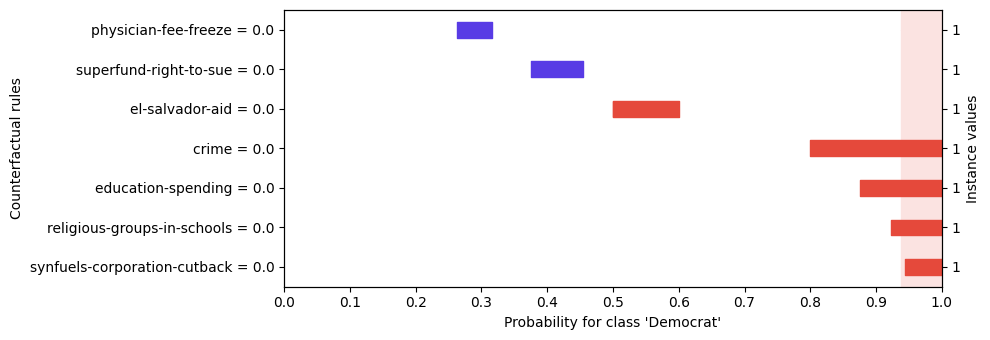

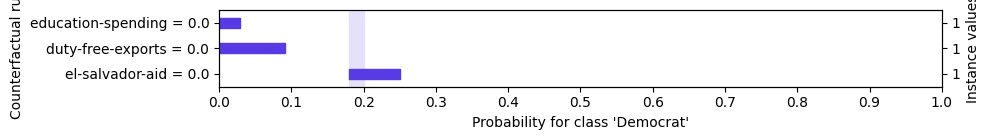

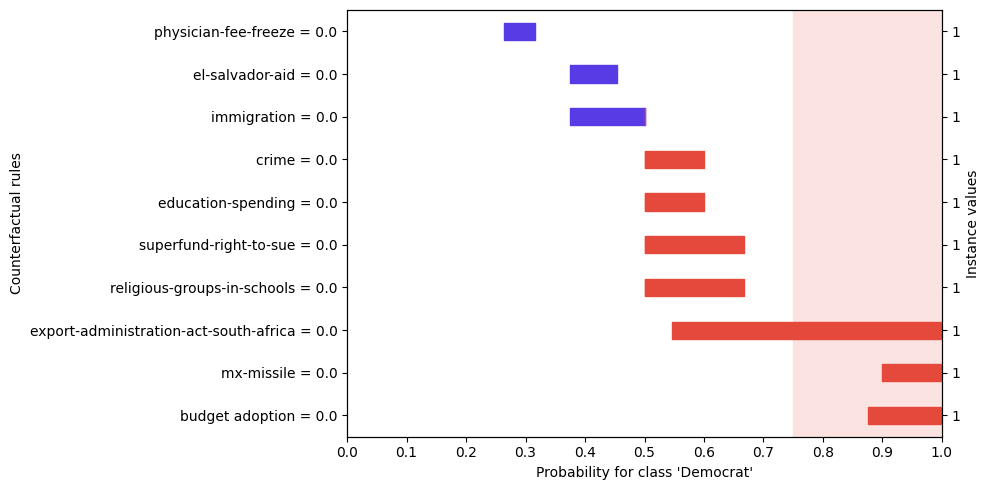

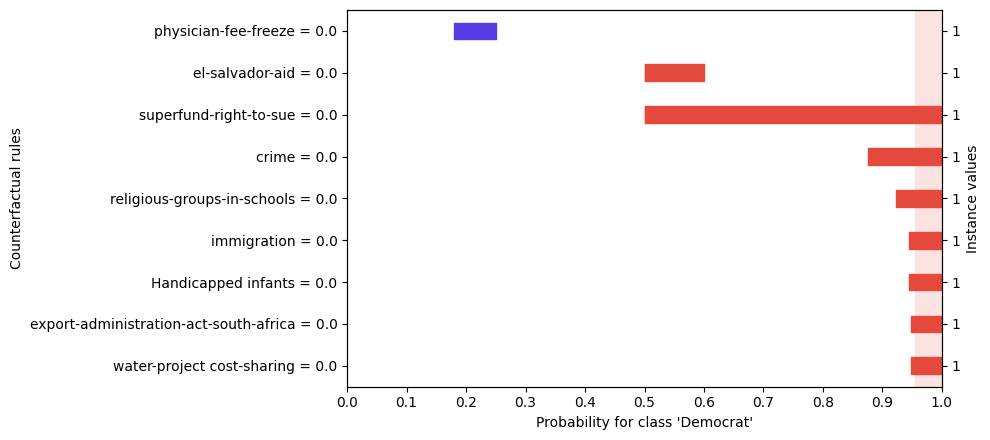

In [28]:
alternative_explanation = ce.explore_alternatives(X_test)
alternative_explanation.plot(filename='../results/vote_alternative.pdf')
# Not used in paper
# alternative_explanation.add_conjunctions()
# alternative_explanation.plot(filename='../results/vote_alternative_conjunctive.pdf', n_features_to_show=15)